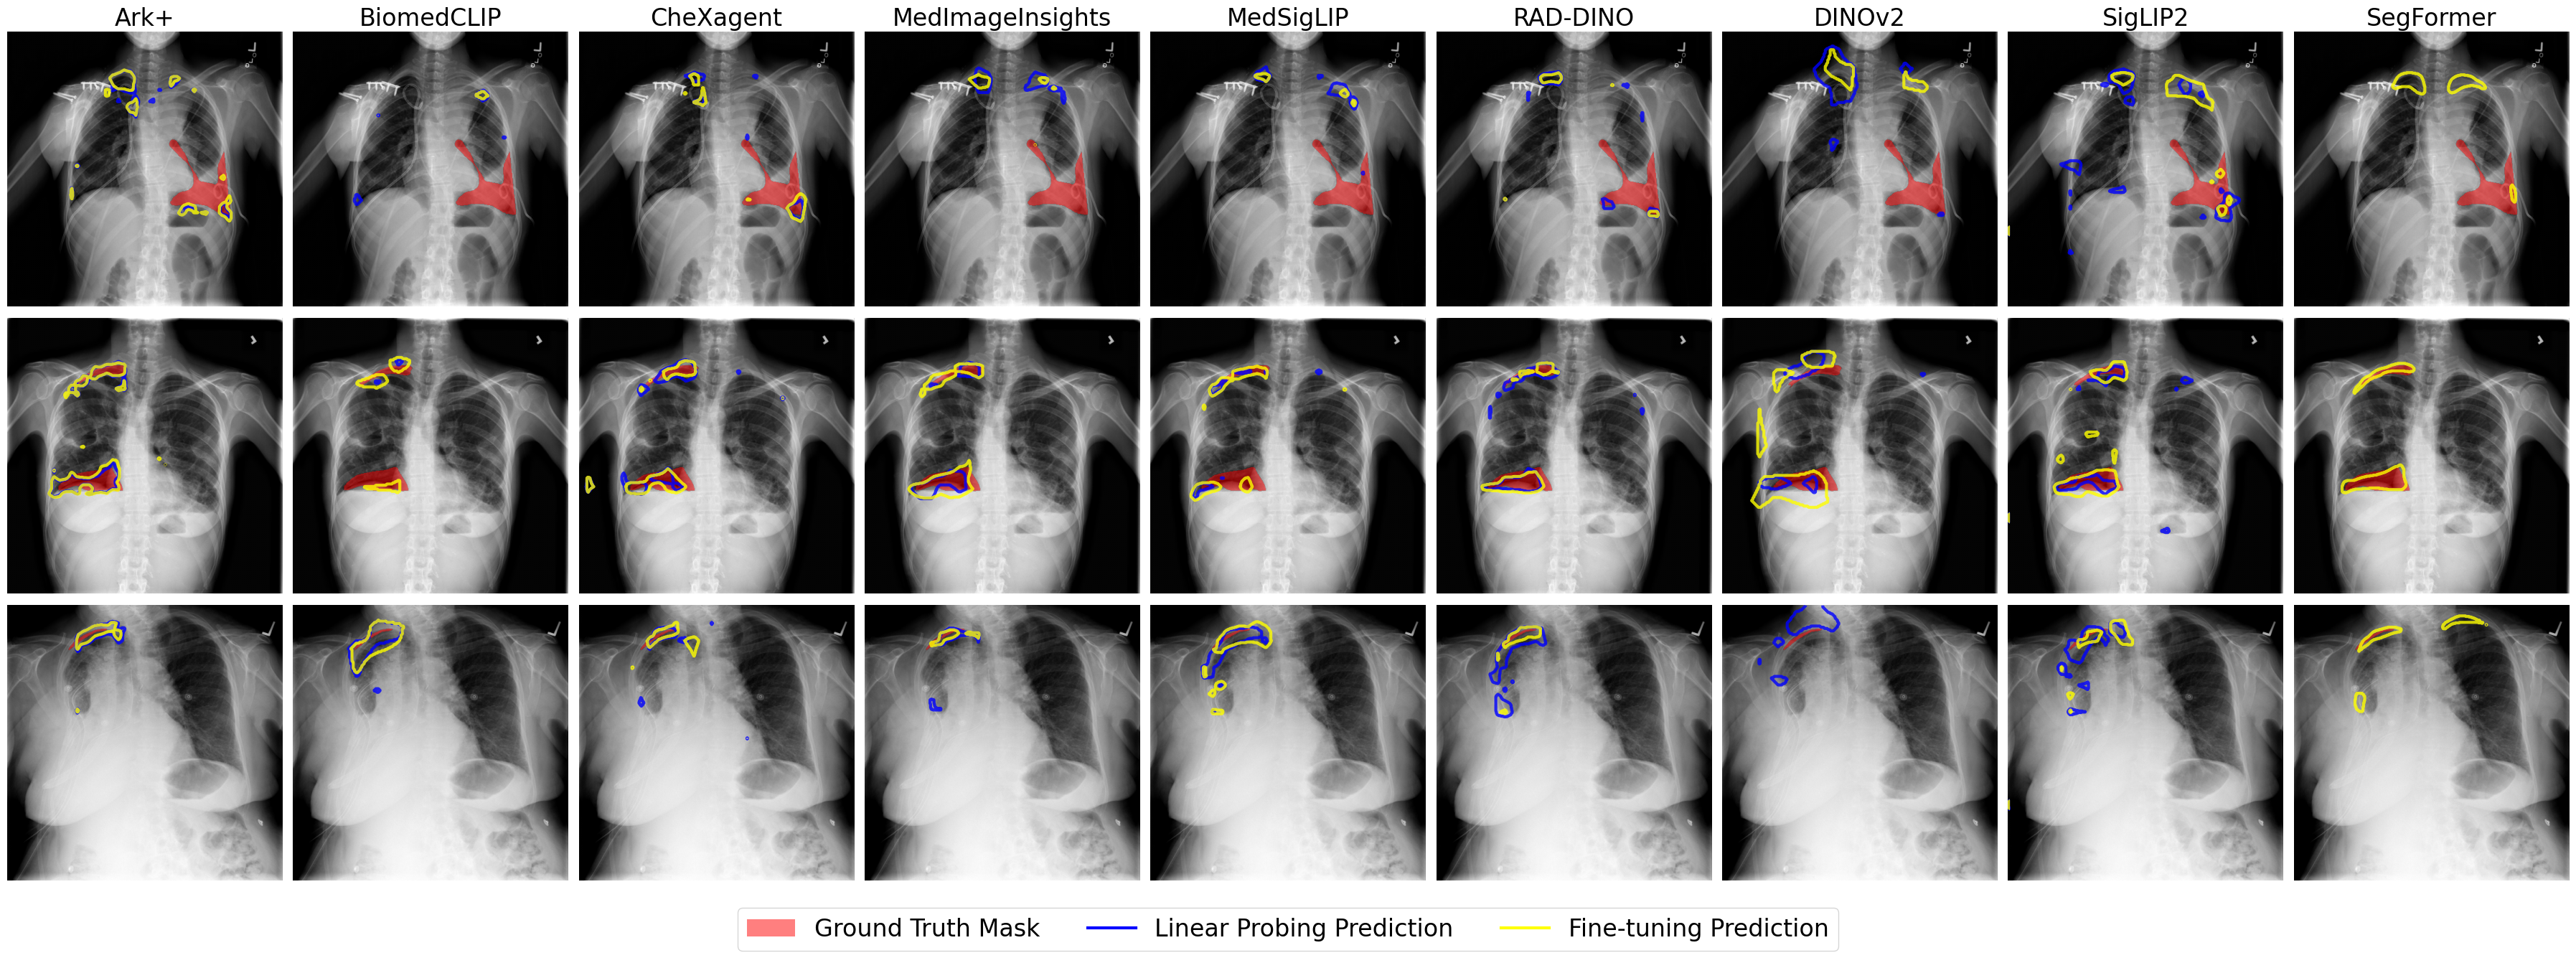

In [69]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# In[2]:
def resize_image(image, width=None, height=None, scale=None, interpolation=cv2.INTER_LINEAR):
    """
    Resize an image using OpenCV.
    """
    h, w = image.shape[:2]
    if scale is not None:
        new_width = int(w * scale)
        new_height = int(h * scale)
    elif width is not None and height is not None:
        new_width = width
        new_height = height
    elif width is not None:
        new_width = width
        new_height = int(h * (width / w))
    elif height is not None:
        new_height = height
        new_width = int(w * (height / h))
    else:
        raise ValueError("Either width, height, or scale must be specified")
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=interpolation)
    return resized_image


# In[12]:


# In[3]:
try:
    inputs = pd.read_csv('./inputs/input_train_ptx_seg_0.csv')
except FileNotFoundError:
    print("Warning: input_train_ptx_seg_0.csv not found. Please ensure the input file is in the correct directory.")
    # Create a dummy dataframe to prevent crashing if the file is missing
    inputs = pd.DataFrame(columns=['ImageId', 'Split'])


# In[4]:
# Set up paths
BASE_PNG = '/mnt/NAS3/datasets/external/SIIM_ACR_Pneumothorax/train_png/'
BASE_GT = '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/CheXagent_ptx_seg_e2e_0/GT/'

# Define models and their corresponding paths for Fine-tuning and Linear Probing
models = {
    'Ark+': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/Ark+(16)_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/Ark+(16)_ptx_seg_fz_0/Pred/'
    },
    'BiomedCLIP': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/BiomedCLIP_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/BiomedCLIP_ptx_seg_fz_0/Pred/'
    },
    'CheXagent': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/CheXagent_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/CheXagent_ptx_seg_fz_0/Pred/'
    },
    'MedImageInsights': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedImageInsights(16)_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedImageInsights(16)_ptx_seg_fz_0/Pred/'
    },
    'MedSigLIP': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedSigLIP_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedSigLIP_ptx_seg_fz_0/Pred/'
    },
    'RAD-DINO': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/RAD-DINO_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/RAD-DINO_ptx_seg_fz_0/Pred/'
    },
    'DINOv2': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/DINOv2_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/DINOv2_ptx_seg_fz_0/Pred/'
    },
    'SigLIP2': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SigLIP2_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SigLIP2_ptx_seg_fz_0/Pred/'
    },
    'SegFormer': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SegFormer_ptx_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SegFormer_ptx_seg_fz_0/Pred/'
    }
}
model_names = list(models.keys())


# In[18]:


inputs = inputs[inputs.Split=='Test']


# In[19]:


# --- VISUALIZATION BLOCK ---

num_samples = 3 
num_cols = len(models)

# Sample images
if len(inputs) >= num_samples:
    samples = inputs.sample(n=num_samples, random_state=56)
else:
    print(f"Warning: Not enough test samples to display. Found {len(inputs)}, need {num_samples}.")
    samples = inputs

# Create subplots grid
fig, axes = plt.subplots(num_samples, num_cols, figsize=(num_cols * 4, num_samples * 4.2))
if num_samples == 1:
    axes = np.array([axes])

# Process each sample image (which corresponds to a row)
for i, (idx, row) in enumerate(samples.iterrows()):
    ImageId = row.ImageId
    
    try:
        png_path = BASE_PNG + ImageId + '.png'
        gt_path = BASE_GT + ImageId + '.png'
        png = resize_image(np.array(Image.open(png_path)), width=512, height=512)
        gt = resize_image(np.array(Image.open(gt_path)), width=512, height=512)
        gt_cmap = plt.cm.colors.ListedColormap(['none', 'red'])
    except FileNotFoundError as e:
        print(f"Error loading base image or GT for {ImageId}: {e}")
        continue

    # --- Columns for Model Predictions ---
    for j, model_name in enumerate(model_names):
        ax = axes[i, j]
        
        ax.imshow(png, cmap='gray')
        ax.imshow(gt, cmap=gt_cmap, alpha=0.5)
        ax.axis('off')
        
        # MODIFIED: Only set the title for the first row of images (i == 0)
        if i == 0:
            ax.set_title(model_name, fontsize=24)
        
        try:
            lp_prob_path = models[model_name]['Linear Probing'] + ImageId + '.png'
            lp_pred_prob = resize_image(np.array(Image.open(lp_prob_path)), width=512, height=512)
            ax.contour(lp_pred_prob, levels=[128], colors=['blue'], linewidths=3, alpha=0.8)
        except FileNotFoundError:
            print(f"Warning: Linear Probing prediction not found for {model_name} on image {ImageId}")

        try:
            ft_prob_path = models[model_name]['Fine-tuning'] + ImageId + '.png'
            ft_pred_prob = resize_image(np.array(Image.open(ft_prob_path)), width=512, height=512)
            ax.contour(ft_pred_prob, levels=[128], colors=['yellow'], linewidths=3, alpha=0.8)
        except FileNotFoundError:
            print(f"Warning: Fine-tuning prediction not found for {model_name} on image {ImageId}")


# --- Add a single legend for the entire figure ---
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='Ground Truth Mask'),
    Line2D([0], [0], color='blue', lw=3, label='Linear Probing Prediction'),
    Line2D([0], [0], color='yellow', lw=3, label='Fine-tuning Prediction')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07), fontsize=24)

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()
plt.show()

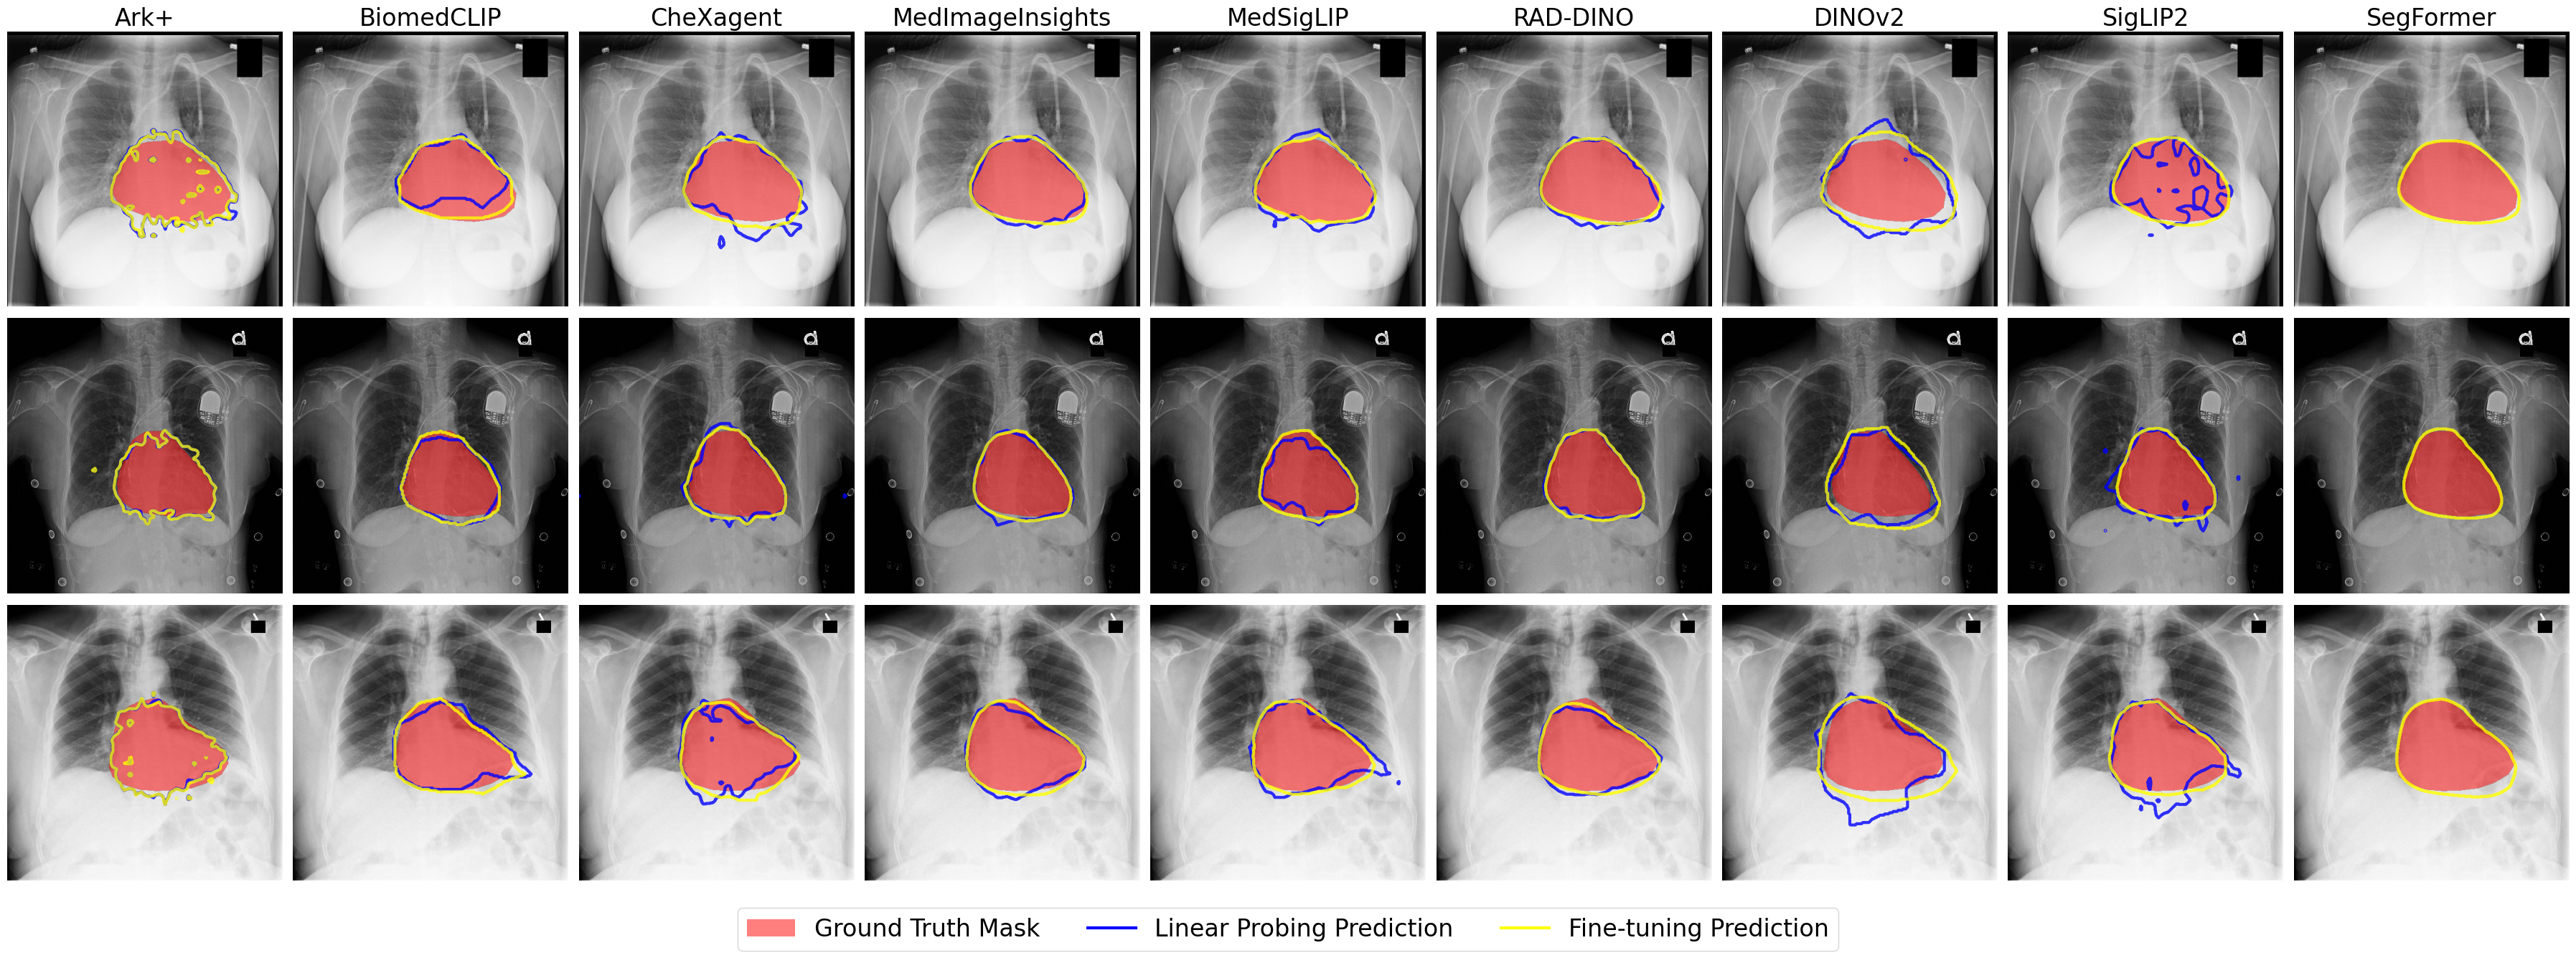

In [68]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# In[2]:
def resize_image(image, width=None, height=None, scale=None, interpolation=cv2.INTER_LINEAR):
    """
    Resize an image using OpenCV.
    """
    h, w = image.shape[:2]
    if scale is not None:
        new_width = int(w * scale)
        new_height = int(h * scale)
    elif width is not None and height is not None:
        new_width = width
        new_height = height
    elif width is not None:
        new_width = width
        new_height = int(h * (width / w))
    elif height is not None:
        new_height = height
        new_width = int(w * (height / h))
    else:
        raise ValueError("Either width, height, or scale must be specified")
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=interpolation)
    return resized_image


# In[12]:


# In[3]:
try:
    inputs = pd.read_csv('./inputs/input_train_cm_cla_0.csv')
except FileNotFoundError:
    print("Warning: input_train_ptx_cm_0.csv not found. Please ensure the input file is in the correct directory.")
    # Create a dummy dataframe to prevent crashing if the file is missing
    inputs = pd.DataFrame(columns=['ImageId', 'Split'])


# In[4]:
# Set up paths
BASE_PNG = '/mnt/NAS3/datasets/internal/EmoryCXRv2/DEID_PNG/'
BASE_GT = '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/CheXagent_cm_seg_e2e_0/GT/'

# Define models and their corresponding paths for Fine-tuning and Linear Probing
models = {
    'Ark+': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/Ark+(16)_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/Ark+(16)_cm_seg_fz_0/Pred/'
    },
    'BiomedCLIP': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/BiomedCLIP_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/BiomedCLIP_cm_seg_fz_0/Pred/'
    },
    'CheXagent': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/CheXagent_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/CheXagent_cm_seg_fz_0/Pred/'
    },
    'MedImageInsights': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedImageInsights(16)_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedImageInsights(16)_cm_seg_fz_0/Pred/'
    },
    'MedSigLIP': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedSigLIP_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/MedSigLIP_cm_seg_fz_0/Pred/'
    },
    'RAD-DINO': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/RAD-DINO_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/RAD-DINO_cm_seg_fz_0/Pred/'
    },
    'DINOv2': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/DINOv2_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/DINOv2_cm_seg_fz_0/Pred/'
    },
    'SigLIP2': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SigLIP2_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SigLIP2_cm_seg_fz_0/Pred/'
    },
    'SegFormer': {
        'Fine-tuning': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SegFormer_cm_seg_e2e_0/Pred/',
        'Linear Probing': '/mnt/NAS3/projects/fli40/FM_evaluation/pred_masks/SegFormer_cm_seg_fz_0/Pred/'
    }
}
model_names = list(models.keys())


# In[18]:


inputs = inputs[inputs.Split=='Test']


# In[19]:


# --- VISUALIZATION BLOCK ---

num_samples = 3 
num_cols = len(models)

# Sample images
if len(inputs) >= num_samples:
    samples = inputs.sample(n=num_samples, random_state=5656)
else:
    print(f"Warning: Not enough test samples to display. Found {len(inputs)}, need {num_samples}.")
    samples = inputs

# Create subplots grid
fig, axes = plt.subplots(num_samples, num_cols, figsize=(num_cols * 4, num_samples * 4.2))
if num_samples == 1:
    axes = np.array([axes])

# Process each sample image (which corresponds to a row)
for i, (idx, row) in enumerate(samples.iterrows()):
    ImagePath = row.ImagePath
    ImageId = row.SOP
    
    try:
        png_path = BASE_PNG + ImagePath #+ '.png'
        gt_path = BASE_GT + ImageId #+ '.png'
        png = resize_image(np.array(Image.open(png_path)), width=512, height=512)
        gt = resize_image(np.array(Image.open(gt_path)), width=512, height=512)
        gt_cmap = plt.cm.colors.ListedColormap(['none', 'red'])
    except FileNotFoundError as e:
        print(f"Error loading base image or GT for {ImageId}: {e}")
        continue

    # --- Columns for Model Predictions ---
    for j, model_name in enumerate(model_names):
        ax = axes[i, j]
        
        ax.imshow(png, cmap='gray')
        ax.imshow(gt, cmap=gt_cmap, alpha=0.5)
        ax.axis('off')
        
        # MODIFIED: Only set the title for the first row of images (i == 0)
        if i == 0:
            ax.set_title(model_name, fontsize=24)
        
        try:
            lp_prob_path = models[model_name]['Linear Probing'] + ImageId #+ '.png'
            lp_pred_prob = resize_image(np.array(Image.open(lp_prob_path)), width=512, height=512)
            ax.contour(lp_pred_prob, levels=[128], colors=['blue'], linewidths=3, alpha=0.8)
        except FileNotFoundError:
            print(f"Warning: Linear Probing prediction not found for {model_name} on image {ImageId}")

        try:
            ft_prob_path = models[model_name]['Fine-tuning'] + ImageId #+ '.png'
            ft_pred_prob = resize_image(np.array(Image.open(ft_prob_path)), width=512, height=512)
            ax.contour(ft_pred_prob, levels=[128], colors=['yellow'], linewidths=3, alpha=0.8)
        except FileNotFoundError:
            print(f"Warning: Fine-tuning prediction not found for {model_name} on image {ImageId}")


# --- Add a single legend for the entire figure ---
legend_elements = [
    Patch(facecolor='red', alpha=0.5, label='Ground Truth Mask'),
    Line2D([0], [0], color='blue', lw=3, label='Linear Probing Prediction'),
    Line2D([0], [0], color='yellow', lw=3, label='Fine-tuning Prediction')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07), fontsize=24)

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()
plt.show()

In [54]:
inputs = pd.read_csv('./inputs/input_train_cm_cla_0.csv')

In [55]:
inputs

,empi_anon,AccessionNumber_anon,Cardiothoracic Ratio (CTR),Cardiomegaly,SOP,ImagePath,Fold,Split
0,65253940,957805420143,0.553691,1.0,1.2.826.0.1.3680043.8.498.28433837278651675165...,65253940/957805420143/1.2.826.0.1.3680043.8.49...,0,Test
1,26199753,2239850936641398,0.559179,1.0,1.2.826.0.1.3680043.8.498.10532983305339320286...,26199753/2239850936641398/1.2.826.0.1.3680043....,0,Test
2,80322454,2838702067172036,0.533069,1.0,1.2.826.0.1.3680043.8.498.52523792034397238997...,80322454/2838702067172036/1.2.826.0.1.3680043....,0,Test
3,47100475,6165122327831953,0.563152,1.0,1.2.826.0.1.3680043.8.498.10389713064242709152...,47100475/6165122327831953/1.2.826.0.1.3680043....,0,Test
4,18922760,2543132504439077,0.596859,1.0,1.2.826.0.1.3680043.8.498.40775042401809315870...,18922760/2543132504439077/1.2.826.0.1.3680043....,0,Test
...,...,...,...,...,...,...,...,...
4995,97046684,381480835025,0.441370,0.0,1.2.826.0.1.3680043.8.498.89093142330201855214...,97046684/381480835025/1.2.826.0.1.3680043.8.49...,4,Train
4996,58009092,3878804050677561,0.536817,1.0,1.2.826.0.1.3680043.8.498.59890408240574822913...,58009092/3878804050677561/1.2.826.0.1.3680043....,4,Train
4997,46525646,8386034425944810,0.502116,1.0,1.2.826.0.1.3680043.8.498.86560064106899912778...,46525646/8386034425944810/1.2.826.0.1.3680043....,4,Train
4998,18215640,985321505908,0.552857,1.0,1.2.826.0.1.3680043.8.498.44355350401940315205...,18215640/985321505908/1.2.826.0.1.3680043.8.49...,4,Train
